# Inference with Approximate Bayesian Computation (ABC)

In [1]:
import argparse
import os
import pickle
from functools import partial
from typing import Union

import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import pyabc
#from pyabc.sampler import RedisEvalParallelSampler
import scipy.stats as stats
import umap
from sklearn.metrics.pairwise import cosine_similarity
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics

from load_bayesflow_model import load_model, EnsembleTrainer
from plotting_routines import sampling_parameter_cis, plot_posterior_1d, plot_sumstats_distance_stats
from summary_stats import compute_summary_stats, reduce_to_coordinates, span, euclidean_distance

In [2]:
# get the job array id and number of processors
test_id = 1 #int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = 10 # int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print('test_id', test_id)
on_cluster = False

test_id 1


In [3]:
population_size = 1000

if on_cluster:
    parser = argparse.ArgumentParser(description='Parse necessary arguments')
    parser.add_argument('-pt', '--port', type=str, default="50004",
                        help='Which port should be use?')
    parser.add_argument('-ip', '--ip', type=str,
                        help='Dynamically passed - BW: Login Node 3')
    args = parser.parse_args()

In [4]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.rate': './CellTypes/CellType/Constant[@symbol="move.duration.rate"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

dt = 30
model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, for inference

# defining the summary statistics function
min_sequence_length = 0
max_sequence_length = 3600 // dt
only_longest_traj_per_cell = True  # mainly to keep the data batchable
cells_in_population = 143

def make_sumstat_dict(data: Union[dict, np.ndarray], return_pred=False) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one full simulation
    assert data.ndim == 3
    # compute the summary statistics
    msd_list, ta_list, v_list, ad_list = compute_summary_stats(data, dt=dt)
    cleaned_dict = {
        'msd': np.array(msd_list).flatten(),
        'ta': np.array(ta_list).flatten(),
        'vel': np.array(v_list).flatten(),
        'ad': np.array(ad_list).flatten(),
    }
    if return_pred:
        # compute the prediction of the regression model
        coeff_matrix = np.array([[-0.,           0.16171273, -0.,         -0.05603923],
                                 [-0.,         -0.,          0.31892324, -0.        ],
                                 [-0.2107947,  -0.10119028, -0.,          0.        ],
                                 [-0.44803216, -0.,         -0.0584819,   0.31803382],
                                 [-0.07227701,  0.,          0.,         -0.52875216],
                                 [-0.,          0.422123,   -0.02283603,  0.        ],
                                 [ 0.30511962,  0.,          0.,          0.        ],
                                 [-0.38812312,  0.0425146,  -0.00355393,  0.        ]])
        cleaned_dict['summary_pred'] = (coeff_matrix.T @ np.array(list(cleaned_dict.values())).flatten()) * \
                                       np.std(list(cleaned_dict.values())) + \
                                       np.mean(list(cleaned_dict.values()))
    return cleaned_dict


def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model, 
                          minimal_length=min_sequence_length, 
                          maximal_length=max_sequence_length,
                          only_longest_traj_per_cell=only_longest_traj_per_cell,
                          )
    
    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((1, cells_in_population, max_sequence_length, 3)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[0, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[0, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
            data_transformed[0, c_id, -len(cell_sim['t']):, 2] = cell_sim['t']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # note: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.rate': 0.1,  # rate of exponential distribution (1/seconds)
    'cell_nodes_real': 50.,  # area of the cell (\mu m^2), macrophages have a volume of 4990\mu m^3 -> radius of 17 if they would are sphere
}


obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.rate': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})

param_names = ['$m_{\\text{dir}}$', '$m_{\\text{rand}}$', '$\lambda$', '$a$']
log_param_names = ['$\log_{10}(m_{\\text{dir}})$', '$\log_{10}(m_{\\text{rand}})$',
                   '$\log_{10}(\lambda)$', '$\log_{10}(a)$']
print(obs_pars)
print(limits_log)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.rate': 0.1, 'cell_nodes_real': 50.0}
{'gradient_strength': (0.0, 4.0), 'move.strength': (0.0, 2.0), 'move.duration.rate': (-4.0, 1.4771212547196624), 'cell_nodes_real': (0.0, 2.4771212547196626)}


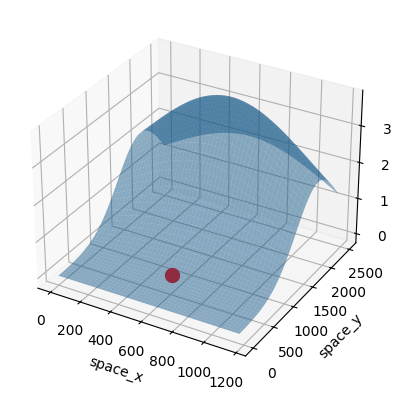

(586.5, 572.5190839694657, 1.801794707907847e-07, 3.68292430295295e-06)

In [5]:
sigma0 = 550
space_x0 = 1173/2
space_y0 = 1500/1.31/2
x0, y0 = 1173/2, (1500+1500/2+270)/1.31
u1 = lambda space_x, space_y: 7/(2*np.pi*(sigma0**2)) *np.exp(-1/2*(((space_x)-(x0))**2+ ((space_y)-(y0))**2)/(sigma0**2))

# plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1173 , 100)
y = np.linspace(0, 2500 , 100)
X, Y = np.meshgrid(x, y)
Z = u1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.5)
# plot start points
ax.scatter(space_x0, space_y0, u1(space_x0, space_y0), color='r', s=100)

ax.set_xlabel('space_x')
ax.set_ylabel('space_y')
plt.show()

space_x0, space_y0, u1(space_x0, space_y0), u1(x0, y0)

In [6]:
# load test data
np.random.seed(42+test_id)
test_params = np.array(list(prior.rvs().values()))
if not os.path.exists(os.path.join(gp, f'test_sim_{test_id}.npy')):
    raise FileNotFoundError('Test data not found')
else:
    test_sim = np.load(os.path.join(gp, f'test_sim_{test_id}.npy'))
    test_sim_full = {'sim_data': test_sim}
results_path = f'abc_results_{test_id}'
test_sim.shape

(1, 143, 120, 3)

In [7]:
prior_draws = np.array([list(prior.rvs().values()) for _ in range(1000)])

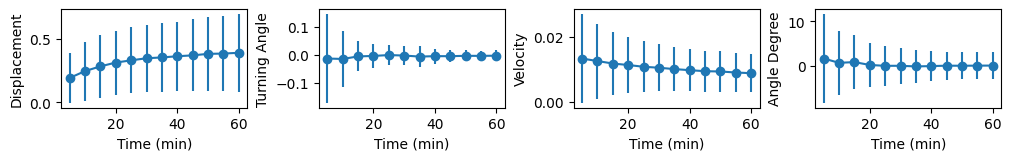

In [8]:
time_step = 10
time_points = np.arange(10, test_sim.shape[2]+1, step=time_step)
statistics_time = []
for t in time_points:
    msd_list, ta_list, v_list, ad_list = compute_summary_stats(test_sim[0, :, :t], dt=dt)
    d = np.mean(msd_list), np.std(msd_list)
    ta = np.mean(ta_list), np.std(ta_list)
    v = np.mean(v_list), np.std(v_list)
    ad = np.mean(ad_list), np.std(ad_list)
    statistics_time.append((d, ta, v, ad))

# plot statistics over time
fig, ax = plt.subplots(1, 4, layout='constrained', figsize=(10, 1.5))
for i in range(4):
    ax[i].errorbar(time_points*dt/60, [s[i][0] for s in statistics_time],
                   yerr=[s[i][1] for s in statistics_time], fmt='-o')
    if i == 0:
        ax[i].set_ylabel(r'Displacement')
    elif i == 1:
        ax[i].set_ylabel(r'Turning Angle')
    elif i == 2:
        ax[i].set_ylabel(r'Velocity')
    elif i == 3:
        ax[i].set_ylabel(r'Angle Degree')
    ax[i].set_xlabel('Time (min)')
#plt.savefig(os.path.join(gp, f'{results_path}/test_sim_statistics_time_{test_id}.pdf'))
plt.show()

## ABC with Wasserstein distance

In [9]:
def obj_func_wass_helper(sim: dict, obs: dict, key: str) -> float:
    x, y = np.array(sim[key]), np.array(obs[key])
    if x.size == 0 or y.size == 0:
        return np.inf
    return stats.wasserstein_distance(x, y)

distances = {
    'msd': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='msd')),
    'ta': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='ta')),
    'vel': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='vel')),
    'ad': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='ad')),
}

# adaptive distance
log_file_weights = f"{results_path}/adaptive_distance_log_{test_id}.txt"
adaptive_wasserstein_distance = pyabc.distance.AdaptiveAggregatedDistance(
    distances=list(distances.values()),
    scale_function=span,
    adaptive=False,  # only pre-calibration
    log_file=log_file_weights
)

In [10]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc = pyabc.ABCSMC(model, prior,
                   distance_function=adaptive_wasserstein_distance,
                   summary_statistics=make_sumstat_dict,
                   population_size=population_size,
                   sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                   #sampler=redis_sampler
                   )

db_path = os.path.join(gp, f"{results_path}/synthetic_{test_id}_test_wasserstein_sumstats.db")
if not os.path.exists(db_path):
    history_abc = abc.new("sqlite:///" + db_path, make_sumstat_dict(test_sim))

    # start the abc fitting
    abc.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_abc = abc.load("sqlite:///" + db_path)
    if len(history_abc.all_runs()) > 1:
        history_abc = abc.load("sqlite:///" + db_path, abc_id=len(history_abc.all_runs()))
adaptive_weights = list(pyabc.storage.load_dict_from_json(log_file_weights).values())[-1]

ABC.Sampler INFO: Parallelize sampling on 10 processes.
INFO:ABC.Sampler:Parallelize sampling on 10 processes.


## ABC with neural network summary statistics

In [11]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    raise FileNotFoundError('Validation data not found')

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)

Mean and std of data: [ 587.005762   1226.92493169 7429.6348269 ] [   51.40666089    60.50555913 11194.06615154]
Mean and std of parameters: [ 1.94728187  0.99232727 -1.42390959  1.33567736] [1.15397718 0.60574734 1.50789037 0.69434402]


In [12]:
# use trained neural net as summary statistics
def make_sumstat_dict_nn(data: Union[dict, np.ndarray], use_npe_summaries: bool = True, return_reduced: bool = False
                         ) -> dict:
    if use_npe_summaries:
        model_id = 0
    else:
        model_id = 10
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]

    trainer = load_model(
        model_id=model_id,
        x_mean=x_mean,
        x_std=x_std,
        p_mean=p_mean,
        p_std=p_std,
    )

    # configures the input for the network
    config_input = trainer.configurator({"sim_data": data})
    # get the summary statistics
    if isinstance(trainer, EnsembleTrainer):
        out_dict = {
            'summary_net': trainer.amortizer.summary_net(config_input).flatten()
        }
    else:
        out_dict = {
            'summary_net': trainer.amortizer.summary_net(config_input['summary_conditions']).numpy().flatten()
        }
    if return_reduced:
        # coeff matrix from regression model
        coeff_matrix = np.array([[-0.,           0.16171273, -0.,         -0.05603923],
                         [-0.,         -0.,          0.31892324, -0.        ],
                         [-0.2107947,  -0.10119028, -0.,          0.        ],
                         [-0.44803216, -0.,         -0.0584819,   0.31803382],
                         [-0.07227701,  0.,          0.,         -0.52875216],
                         [-0.,          0.422123,   -0.02283603,  0.        ],
                         [ 0.30511962,  0.,          0.,          0.        ],
                         [-0.38812312,  0.0425146,  -0.00355393,  0.        ]])

        out_dict['summary_pred'] = (coeff_matrix.T @ out_dict['summary_net']) * p_std + p_mean
    if model_id == 10:
        # renormalize the parameters
        out_dict['summary_net'] = out_dict['summary_net'] * p_std + p_mean

    del trainer
    return out_dict


if on_cluster:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # note: remember also change tiff path in model.xml!
else:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

In [13]:
# %%time
# print(make_sumstat_dict_nn(test_sim), test_params)
#
# p = 1
# summary_error = (np.abs(make_sumstat_dict_nn(test_sim, use_npe_summaries=False)['summary_net']-test_params)**p).sum() ** (1 / p)
# print(make_sumstat_dict_nn(test_sim, use_npe_summaries=False), test_params)
# print('error:', summary_error)

In [14]:
# abc with summary net trained on posterior mean
abc_nn = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance, Wasserstein distance is not possible
                      population_size=population_size,
                      summary_statistics=partial(make_sumstat_dict_nn, use_npe_summaries=False),
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, f"{results_path}/synthetic_{test_id}_test_nn_sumstats_posterior_mean.db")

if not os.path.exists(db_path):
    history_nn = abc_nn.new("sqlite:///" + db_path, make_sumstat_dict_nn(test_sim))

    # start the abc fitting
    abc_nn.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_nn = abc_nn.load("sqlite:///" + db_path)
    if len(history_nn.all_runs()) > 1:
        history_nn = abc_nn.load("sqlite:///" + db_path, abc_id=len(history_nn.all_runs()))

ABC.Sampler INFO: Parallelize sampling on 10 processes.
INFO:ABC.Sampler:Parallelize sampling on 10 processes.


In [15]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

# abc with summary net trained with NPE
abc_npe = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance, Wasserstein distance is not possible
                      population_size=population_size,
                      summary_statistics=partial(make_sumstat_dict_nn, use_npe_summaries=True),
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, f"{results_path}/synthetic_{test_id}_test_nn_sumstats.db")
if not os.path.exists(db_path):
    history_npe = abc_npe.new("sqlite:///" + db_path,
                              make_sumstat_dict_nn(test_sim, use_npe_summaries=True))

    # start the abc fitting
    abc_npe.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_npe = abc_npe.load("sqlite:///" + db_path)
    if len(history_npe.all_runs()) > 1:
        # first run failed
        history_npe = abc_npe.load("sqlite:///" + db_path, abc_id=len(history_npe.all_runs()))

ABC.Sampler INFO: Parallelize sampling on 10 processes.
INFO:ABC.Sampler:Parallelize sampling on 10 processes.


abc Generations: 16 Samples: 65967 Time (h): 2.14


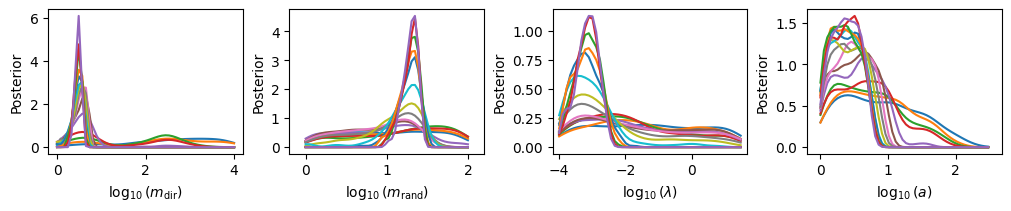

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/sample.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/walltime.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


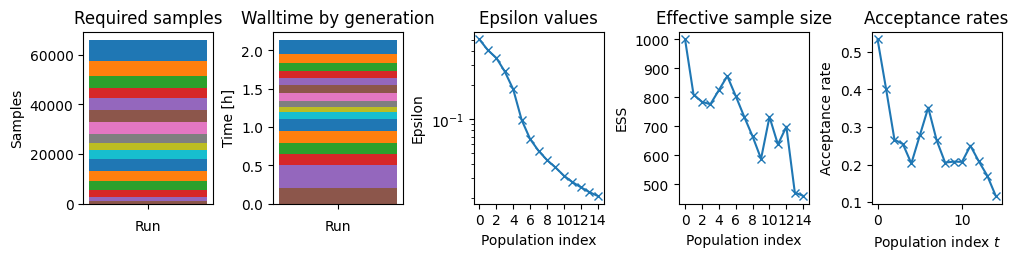

abc_mean Generations: 16 Samples: 26303 Time (h): 1.76


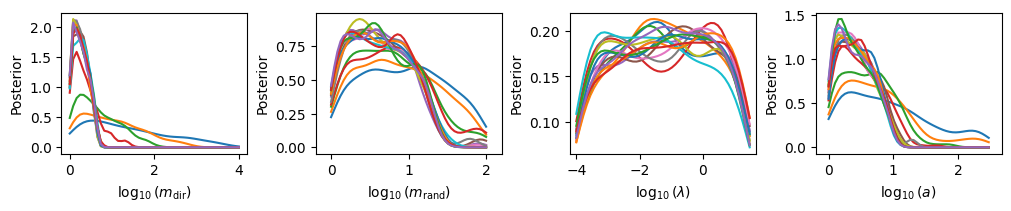

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/sample.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/walltime.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


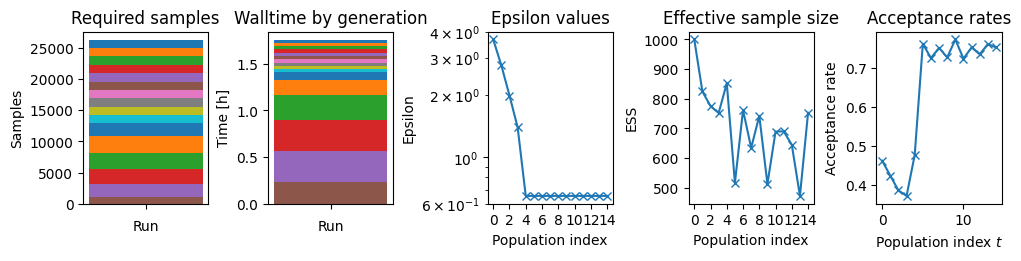

abc_npe Generations: 16 Samples: 87781 Time (h): 3.66


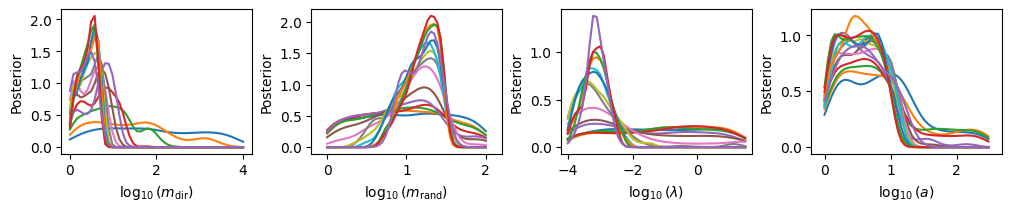

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/sample.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/pyabc/visualization/walltime.py:376: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


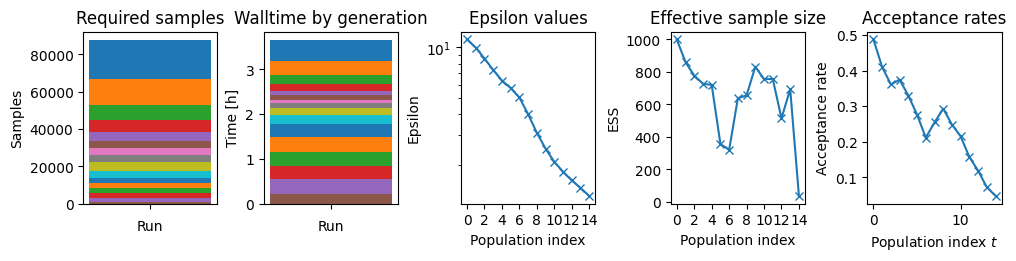

In [16]:
for hist, name in zip([history_abc, history_nn, history_npe], ['abc', 'abc_mean', 'abc_npe']):
    if hist is None:
        continue
    diff_time = hist.get_all_populations().population_end_time - hist.get_abc().start_time
    total_time = [diff.total_seconds() for diff in diff_time][-1] / 60 / 60
    print(name,
          'Generations:', len(hist.get_all_populations()['t']),  # including precalibration
          'Samples:', hist.get_all_populations()['samples'].sum(),
          'Time (h):', np.round(total_time, 2))
    fig, ax = plt.subplots(1, len(param_names), layout='constrained', figsize=(10, 2))
    for i, param in enumerate(limits.keys()):
        for t in range(hist.max_t + 1):
            df, w = hist.get_distribution(m=0, t=t)
            if 'move.duration.mean' in df.columns:
                df['move.duration.rate'] = df['move.duration.mean']  # there was mistake in the name
            pyabc.visualization.plot_kde_1d(
                df,
                w,
                xmin=limits_log[param][0],
                xmax=limits_log[param][1],
                x=param,
                xname=log_param_names[i],
                ax=ax[i],
                label=f"PDF t={t}",
            )
        ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
    fig.set_constrained_layout(True)
    plt.savefig(os.path.join(gp, f'{results_path}/synthetic_{test_id}_population_kdes_{name}.pdf'), bbox_inches='tight')
    plt.show()

    fig, arr_ax = plt.subplots(1, 5, figsize=(10, 2.5), layout='constrained')
    arr_ax = arr_ax.flatten()
    pyabc.visualization.plot_sample_numbers(hist, ax=arr_ax[0])
    arr_ax[0].get_legend().remove()
    pyabc.visualization.plot_walltime(hist, ax=arr_ax[1], unit='h')
    arr_ax[1].get_legend().remove()
    pyabc.visualization.plot_epsilons(hist, ax=arr_ax[2])
    pyabc.visualization.plot_effective_sample_sizes(hist, ax=arr_ax[3])
    pyabc.visualization.plot_acceptance_rates_trajectory(hist, ax=arr_ax[4])
    fig.set_constrained_layout(True)
    plt.savefig(os.path.join(gp, f'{results_path}/synthetic_{test_id}_diagnostics_{name}.pdf'), bbox_inches='tight')
    plt.show()

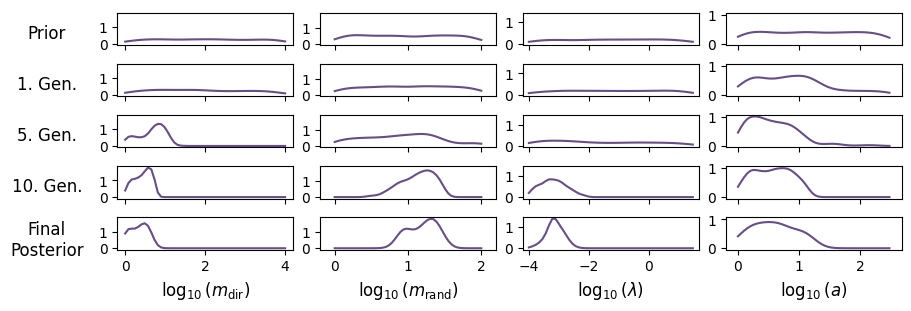

In [51]:
rows = [-1, 0, 4, 9, 14]
fig, ax = plt.subplots(len(rows), len(param_names), sharey='col', sharex='col', layout='constrained', figsize=(9, 3))
for i, param in enumerate(limits.keys()):
    j = 0
    for t in range(-1, hist.max_t + 1):
        df, w = hist.get_distribution(m=0, t=t)
        if not t in rows:
            continue
        if 'move.duration.mean' in df.columns:
            df['move.duration.rate'] = df['move.duration.mean']  # there was mistake in the name
        if t == -1:
            # add prior
            df_prior = prior.rvs(size=1000)
            df = pd.DataFrame(df_prior)
            w = np.ones(len(df)) / len(df)
        artists = pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[j, i],
            label=f"PDF t={t}",
        )
        line = ax[j, i].get_lines()[-1]
        line.set_color('#674E85')
        #line.set_linewidth(2)
        ax[j, i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
        if t != 14:
            ax[j, i].set_xlabel('')
        if t == -1:
            #ax[j, i].set_title(f'Prior')
            ax[j, i].set_ylabel("Prior", rotation='horizontal')
        elif t == 14:
            ax[j, i].set_ylabel(f'Final\nPosterior', rotation='horizontal')
        else:
            ax[j, i].set_ylabel(f'{t+1}. Gen.', rotation='horizontal')
        if i != 0:
            ax[j, i].set_ylabel("")
        j += 1
for j in range(len(rows)):
    ax[j, 0].yaxis.set_label_coords(-0.4, 0.1)
ax[-1, 0].yaxis.set_label_coords(-0.4, -0.3)
for a in ax.flatten():
    # set font size
    a.tick_params(labelsize=10)
    a.xaxis.label.set_size(12)
    a.yaxis.label.set_size(12)
fig.set_constrained_layout(True)
plt.savefig(os.path.join(gp, f'{results_path}/synthetic_{test_id}_population_kdes_list.pdf'), bbox_inches='tight')
plt.show()

# Synthetic Tests

## Compare Posterior Samples

In [ ]:
# get posterior samples
posterior_samples = {}
for hist, name in zip([history_abc, history_nn, history_npe], ['abc', 'abc_mean', 'abc_npe']):
    if hist is None:
        continue
    abc_df, abc_w = hist.get_distribution()
    if 'move.duration.mean' in abc_df.columns:
        abc_df['move.duration.rate'] = abc_df['move.duration.mean']  # there was mistake in the name
    posterior_samples[name] = pyabc.resample(abc_df[limits.keys()].values, abc_w, n=1000)

# add bayesflow posterior samples
posterior_samples['npe'] = np.load(f'abc_results_{test_id}/posterior_samples_npe.npy')

# pickle samples
#with open(f'posterior_samples_{test_id}.pickle', 'wb') as f:
#        pickle.dump(posterior_samples, f)

In [ ]:
labels_colors = {
    'abc': ('ABC hand-crafted summaries', '#9AB8D7', 'ABC'),
    'abc_mean': ('ABC posterior mean summaries', '#C4B7D4', 'ABC-PM'),
    'abc_npe': ('ABC inference-tailored summaries', '#EEBC88', 'ABC-NPE'),
    'npe': ('NPE jointly learned summaries', '#A7CE97', 'NPE')
}

colors = [labels_colors[name][1] for name in posterior_samples.keys()]
labels = [labels_colors[name][0] for name in posterior_samples.keys()]

In [ ]:
fig = plot_posterior_1d(
    posterior_samples=posterior_samples,
    prior_draws=prior_draws,
    log_param_names=log_param_names,
    test_sim=test_sim,
    test_params=test_params,
    labels_colors=labels_colors,
    make_sumstat_dict_nn=make_sumstat_dict_nn,
    save_path=os.path.join(gp, f'{results_path}/synthetic_posterior_all_rows.pdf')
)

In [ ]:
prior_mean = np.mean(prior_draws, axis=0)
prior_std = np.std(prior_draws, axis=0)

def compute_z_score(posterior_mean):
    return (posterior_mean - prior_mean) / prior_std

def compute_contraction(posterior_std):
    return 1. - (posterior_std / prior_std)

posterior_stats = {}
for name, ps in posterior_samples.items():
    posterior_stats[name] = {
        'mean': np.mean(ps, axis=0),
        'std': np.std(ps, axis=0),
        'median': np.median(ps, axis=0),
        'z_score': compute_z_score(np.mean(ps, axis=0)),
        'contraction': compute_contraction(np.std(ps, axis=0))
    }

In [ ]:
z_scores = [posterior_stats[name]['z_score'] for name in posterior_samples.keys()]
contractions = [posterior_stats[name]['contraction'] for name in posterior_samples.keys()]

# Plotting Z-scores and contractions for both methods
fig, ax1 = plt.subplots(figsize=(8, 4), tight_layout=True)

# Z-Scores for both methods
for i, z in enumerate(z_scores):
    ax1.bar(np.arange(len(param_names)) + 0.2 * i, z, width=0.15, align='center', color=colors[i],
            label=labels[i])
ax1.set_ylabel('Z-Score')
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(len(param_names)) + 0.3)
ax1.set_xticklabels(log_param_names)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax1.grid()

# Plot Contractions for both methods on secondary axis
ax2 = ax1.twinx()
for i, c in enumerate(contractions):
    ax2.plot(np.arange(0.3, len(param_names)), c, color=colors[i], marker='o', linestyle='--')
ax2.set_ylabel('--●--  Contraction')
ax2.tick_params(axis='y')
# get maximal y-limit of ax1
max_y = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
min_y = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ax1.set_ylim(min_y, max_y)
ax2.set_ylim(min_y, max_y)

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
fig.legend(handles1, labels1,
           loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=2)
fig.savefig(os.path.join(gp, f'{results_path}/synthetic_z_scores_contraction_{test_id}.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
#ordering = [0,4,1,5,2,6,3,7]
ordering = np.concatenate([[i,i+4, i+8, i+12] for i in range(4)])
all_params = np.concatenate((posterior_samples['abc'],
                             posterior_samples['abc_mean'],
                             posterior_samples['abc_npe'],
                             posterior_samples['npe']), axis=-1)
log_param_names_plot = np.array(
    [f'{n} $\qquad$ ABC hand-crafted' for n in log_param_names] +
    [f'ABC posterior mean' for n in log_param_names] +
    [f'ABC inference tailored' for n in log_param_names] +
    [f'NPE' for n in log_param_names]
)[ordering]
param_names_plot = np.array(
    [f'{n} $\qquad$ ABC hand-crafted' for n in param_names] +
    [f'ABC posterior mean' for n in param_names] +
    [f'ABC inference tailored' for n in param_names] +
    [f'NPE' for n in param_names]
)[ordering]
color_list = colors*len(param_names)

ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.concatenate((test_params, test_params, test_params, test_params))[ordering] if test_params is not None else None,
    prior_bounds=limits_log.values() if test_params is not None else None,
    param_names=log_param_names_plot,
    alpha=[95, 90 , 80],
    color_list=color_list,
    show_median=False if test_params is not None else True,
    size=(7, 4),
    legend_bbox_to_anchor=(0.45,1) if test_params is not None else (0.31,1)
)
plt.savefig(os.path.join(gp, f'{results_path}/synthetic_posterior_credible_intervals_log_{test_id}.pdf'))
plt.show()

all_params = np.power(10, all_params)
ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.power(10, np.concatenate((test_params, test_params, test_params, test_params))[ordering]) if test_params is not None else None,
    param_names=param_names_plot,
    alpha=[95, 90 , 80],
    color_list=color_list,
    show_median=False if test_params is not None else True,
    size=(7, 4),
    legend_bbox_to_anchor=(0.99,0.35)
)
#plt.savefig(os.path.join(gp, f'{results_path}/synthetic_posterior_credible_intervals.pdf'))
plt.show()

## Compare Simulations from Posterior Samples

In [ ]:
%%time
file_name = os.path.join(gp, f'{results_path}/synthetic_posterior_simulations.pickle')
n_sim = 100
if os.path.exists(file_name):
    with open(file_name, 'rb') as f:
        posterior_simulations = pickle.load(f)
else:
    posterior_simulations = {}
    for name, ps in posterior_samples.items():
        print('Simulating', name)
        @delayed
        def wrapper_fun(sample_i):
            _sim_dict = {key: p for key, p in zip(obs_pars.keys(), ps[sample_i])}
            _posterior_sim = model(_sim_dict)
            return _posterior_sim['sim']

        sim_list = Parallel(n_jobs=6, verbose=1)(wrapper_fun(i) for i in range(n_sim))
        posterior_simulations[name] = np.concatenate(sim_list)

    with open(file_name, 'wb') as f:
       pickle.dump(posterior_simulations, f)

simulation_sumstats = {}
for name, ps in posterior_simulations.items():
    print('Processing', name)
    simulation_sumstats[name] = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in ps]
    for i in range(len(simulation_sumstats[name])):
        simulation_sumstats[name][i]['nn'] = make_sumstat_dict_nn(ps[i][np.newaxis], use_npe_summaries=True)['summary_net']

In [ ]:
def obj_func_comparison(sim: dict, obs: dict, return_marginal: bool = False, weights: Union[dict, list] = None) -> Union[float, np.ndarray]:
    total = np.zeros(len(sim.keys()))
    for k_i, key in enumerate(sim):
        if key == 'nn':
            # for the neural network summary statistics we use the Euclidean distance
            total[k_i] = euclidean_distance(sim['nn'], obs['nn'])
            continue # no weights applied
        elif key == 'umap':
            # distance already computed
            total[k_i] = obs['umap']
            continue # no weights applied
        else:
            total[k_i] = distances[key](sim, obs)
        if weights is not None:
            if isinstance(weights, dict):
                total[k_i] = total[k_i] * weights[key]
            elif isinstance(weights, list):
                total[k_i] = total[k_i] * weights[k_i]
            else:
                raise ValueError('Weights must be a list or a dictionary')
    if return_marginal:
        return total
    return total.sum()

In [ ]:
test_sim_dict = make_sumstat_dict(test_sim)
test_sim_dict['nn'] = make_sumstat_dict_nn(test_sim, use_npe_summaries=True)['summary_net']
test_sim_dict['umap'] = None  # will be computed later

In [ ]:
# compute the UMAP embedding and similarity matrices

# 1) Stack & flatten as you already do
all_trajec = np.concatenate((
    test_sim,
    posterior_simulations['abc'],
    posterior_simulations['abc_mean'],
    posterior_simulations['abc_npe'],
    posterior_simulations['npe'],
), axis=0).reshape((4*n_sim+1)*143, 120, 3)
# flatten the 3 coords into a single feature-vector per trajectory
all_trajec = np.concatenate([
    all_trajec[..., 0], all_trajec[..., 1], all_trajec[..., 2]
], axis=1)
all_trajec[np.isnan(all_trajec)] = -1

# how many samples per group?
n_real = test_sim[0].shape[0]
n_abc  = posterior_simulations['abc'].shape[1] * posterior_simulations['abc'].shape[0]
n_abc_mean  = posterior_simulations['abc_mean'].shape[1] * posterior_simulations['abc_mean'].shape[0]
n_abc_npe = posterior_simulations['abc_npe'].shape[1] * posterior_simulations['abc_npe'].shape[0]
n_npe  = posterior_simulations['npe'].shape[1] * posterior_simulations['npe'].shape[0]

# 2) Compute UMAP embedding once
reducer   = umap.UMAP(random_state=0, n_components=10)
embedding = reducer.fit_transform(all_trajec)  # shape=(N,n_components)

# 3) Compute full similarity matrices
sim_emb  = cosine_similarity(embedding)       # (N × N) in UMAP space

# 4) For each method, pull similarities to the real set
#    sim_to_real_method = sim_norm[0:n_real, idx_start:idx_end]
ranges = {
    'abc':       slice(n_real,  n_real + n_abc),
    'abc_mean':  slice(n_real + n_abc, n_real + n_abc + n_abc_mean),
    'abc_npe':   slice(n_real + n_abc + n_abc_mean, n_real + n_abc + n_abc_mean + n_abc_npe),
    'npe':       slice(n_real + n_abc + n_abc_mean + n_abc_npe, None),
}

data = {}
for name, sl in ranges.items():
    # all sim-vs-all real similarities
    data[name] = sim_emb[:n_real, sl]

# append to summary stats
for method, sim in simulation_sumstats.items():
    for i, ss in enumerate(sim):
        simulation_sumstats[method][i]['umap'] = np.median(data[method][:, i*143:(i+1)*143])

In [ ]:
plot_sumstats_distance_stats(obj_func_comparison,
                             test_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             title='Wasserstein Distance',
                             colors=colors,
                             ylog_scale=True,
                             path=os.path.join(gp, f'{results_path}/synthetic_sumstats_comparison_{test_id}.pdf')
                             )

print(*test_sim_dict.keys())
print(adaptive_weights)
plot_sumstats_distance_stats(partial(obj_func_comparison, weights=adaptive_weights),
                             test_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             colors=colors,
                             ylog_scale=True,
                             #path=os.path.join(gp, f'{results_path}/synthetic_sumstats_comparison.pdf')
                             )

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Patch

def plot_sumstats_distance_stats_test(obj_func_comparison: callable,
                                 test_sim_dict: dict,
                                 sumstats_list: list[list],
                                 labels: list[str] = None,
                                 colors: list[str] = None,
                                 ylog_scale: bool = False,
                                 title: str = 'Weighted\nWasserstein Distance',
                                 path: str = None,
                                 fdr_q: float = 0.05,
                                 correct_across_all: bool = False,
                                 print_results: bool = True):
    """
    Violin plots of distances with pairwise Mann Whitney U tests (FDR corrected)
    """
    # compute marginal distances
    marginal_distances_list = []
    for sumstats in sumstats_list:
        md = np.zeros((len(sumstats), len(test_sim_dict)))
        for i, st in enumerate(sumstats):
            md[i, :] = obj_func_comparison(test_sim_dict, st, return_marginal=True)
        marginal_distances_list.append(md)
    marginal_distances_list = np.array(marginal_distances_list)  # (n_methods, n_sim, statistics)
    print(marginal_distances_list.shape)

    n_stats   = len(test_sim_dict)
    n_methods = len(sumstats_list)
    name_plots = ['Displacement', 'Turning Angle', 'Velocity', 'Angle Degree', 'NPE Summary', 'UMAP']
    order = [0, 2, 3, 1, 4, 5]

    # pairwise Mann Whitney tests
    method_pairs = list(combinations(range(n_methods), 2))
    raw_p = {g: [] for g in range(n_stats)}
    store = {g: [] for g in range(n_stats)}

    for grp_idx in range(n_stats):
        group_data = marginal_distances_list[:, :, grp_idx]
        for (i, j) in method_pairs:
            x = np.asarray(group_data[i], float)
            y = np.asarray(group_data[j], float)
            x = x[np.isfinite(x)]
            y = y[np.isfinite(y)]
            if len(x) < 2 or len(y) < 2:
                U, p, r_rb = np.nan, np.nan, np.nan
            else:
                res = mannwhitneyu(x, y, alternative='two-sided', method='auto')
                U, p = res.statistic, res.pvalue
                r_rb = 1.0 - 2.0 * U / (len(x) * len(y))
            raw_p[grp_idx].append(p)
            store[grp_idx].append(((i, j), U, p, r_rb))

    # FDR correction
    if correct_across_all:
        all_p = np.array([p for g in range(n_stats) for p in raw_p[g]], float)
        mask = np.isfinite(all_p)
        adj_all = np.full_like(all_p, np.nan)
        if mask.any():
            _, p_corr, _, _ = multipletests(all_p[mask], alpha=fdr_q, method='fdr_bh')
            adj_all[mask] = p_corr
        adj_p = {}
        idx = 0
        for g in range(n_stats):
            k = len(raw_p[g])
            adj_p[g] = list(adj_all[idx:idx+k])
            idx += k
    else:
        adj_p = {}
        for g in range(n_stats):
            pvec = np.array(raw_p[g], float)
            mask = np.isfinite(pvec)
            p_adj = np.full_like(pvec, np.nan)
            if mask.any():
                _, p_corr, _, _ = multipletests(pvec[mask], alpha=fdr_q, method='fdr_bh')
                p_adj[mask] = p_corr
            adj_p[g] = list(p_adj)

    # optional printing
    if print_results:
        fam = "all groups" if correct_across_all else "per group"
        print(f"Mann Whitney U tests with BH FDR at q={fdr_q} corrected {fam}")
        for g in range(n_stats):
            print(f"\nGroup {g}  {name_plots[g]}")
            for k, ((i, j), U, p, r_rb) in enumerate(store[g]):
                p_adj = adj_p[g][k]
                sig = "yes" if np.isfinite(p_adj) and p_adj < fdr_q else "no"
                print(f"  {labels[i]} vs {labels[j]}  U={U:.3f}  p={p:.3e}  p_adj={p_adj:.3e}  r_rb={r_rb:.3f}  sig={sig}")

    # plotting
    fig, axes = plt.subplots(1, n_stats, figsize=(10, 2), layout="constrained")
    if n_stats == 1:
        axes = [axes]

    for ax, grp_idx in zip(axes, order):
        data = marginal_distances_list[:, :, grp_idx]
        cleaned = [np.asarray(g)[np.isfinite(g)] for g in data]

        parts = ax.violinplot(cleaned, showmeans=False, showextrema=False)
        for pc, col in zip(parts['bodies'], colors):
            pc.set_facecolor(col)
            pc.set_edgecolor('black')
            pc.set_alpha(0.8)

        # draw medians
        medians = [np.median(d) if len(d) else np.nan for d in cleaned]
        ax.scatter(np.arange(1, n_methods+1), medians, color='black', s=10, zorder=3)

        ax.set_xlabel(name_plots[grp_idx], fontsize=12)
        ax.set_xticks(np.arange(1, n_methods+1))
        ax.set_xticklabels([], rotation=45, ha='right')
        if ylog_scale and grp_idx != 5:
            ax.set_yscale('log')
        if grp_idx < 4:
            ax.set_ylim(0.0001, 20)
            if grp_idx != 0:
                ax.set_yticks([])
        if grp_idx == 4:
            ax.set_ylim(0.1, 20)

        # significance annotations
        y_max = max((np.max(c) for c in cleaned if c.size), default=np.nan)
        if not np.isfinite(y_max):
            continue
        gap = 0.08 * y_max if ax.get_yscale() == 'linear' else 1.2
        step = 0.06 * y_max if ax.get_yscale() == 'linear' else 1.2
        level = 0
        for k, ((i, j), U, p, r_rb) in enumerate(store[grp_idx]):
            p_adj = adj_p[grp_idx][k]
            if not np.isfinite(p_adj) or p_adj >= fdr_q:
                continue
            if p_adj < 0.001:
                stars = '***'
            elif p_adj < 0.01:
                stars = '**'
            else:
                stars = '*'
            x1, x2 = i+1, j+1
            y = y_max + gap + level * step
            ax.plot([x1, x1, x2, x2], [y, y+0.02*y, y+0.02*y, y], lw=1, c='black')
            ax.text((x1+x2)/2, y+0.02*y, stars, ha='center', va='bottom', fontsize=9)
            level += 1

    axes[0].set_ylabel(title, fontsize=12)
    axes[-2].set_ylabel(r"$L^1$ Distance", fontsize=12)
    axes[-1].set_ylabel("Cosine Similarity", fontsize=12)
    for a in axes:
        a.tick_params(axis="x", labelsize=10)
        a.tick_params(axis="y", labelsize=10)

    handles = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.33), fontsize=12)

    if path:
        plt.savefig(path, bbox_inches='tight')
    plt.show()

In [ ]:
plot_sumstats_distance_stats_test(obj_func_comparison,
                             test_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             title='Wasserstein Distance',
                             colors=colors,
                             ylog_scale=True,
                             #path=os.path.join(gp, f'{results_path}/synthetic_sumstats_comparison_{test_id}.pdf')
                             )

In [ ]:
from scipy.stats import mannwhitneyu
from itertools import combinations

def rank_biserial(x, y, u_stat):
    """
    Calculate rank-biserial correlation (effect size for Mann-Whitney U).
    r = 1 - (2U)/(n1*n2)
    Range: [-1, 1] where 0 = no effect, ±1 = complete separation
    """
    n1, n2 = len(x), len(y)
    r = 1 - (2 * u_stat) / (n1 * n2)
    return r

def interpret_effect_size(r):
    """Interpret rank-biserial correlation."""
    abs_r = abs(r)
    if abs_r < 0.1:
        return "negligible"
    elif abs_r < 0.3:
        return "small"
    elif abs_r < 0.5:
        return "medium"
    else:
        return "large"

def plot_sumstats_distance_stats_test(obj_func_comparison: callable,
                                 test_sim_dict: dict,
                                 sumstats_list: list[list],
                                 labels: list[str] = None,
                                 colors: list[str] = None,
                                 ylog_scale: bool = False,
                                 title: str = 'Weighted\nWasserstein Distance',
                                 path: str = None,
                                 alpha: float = 0.05,
                                 correction: str = 'bonferroni',
                                 min_effect_size: float = 0.3):
    """
    Plot boxplots of the distance between each simulation method and the test simulation,
    separately for each summary-stat category. Tests whether the summary statistics
    themselves differ between methods.

    Parameters
    ----------
    alpha : float
        Significance level for statistical tests (default: 0.05)
    correction : str
        Multiple comparison correction method: 'bonferroni' or 'none' (default: 'bonferroni')
    min_effect_size : float
        Minimum rank-biserial r to consider meaningful (default: 0.3 for medium effect)
    """
    # 1) compute marginal distances for each summary-stat group
    marginal_distances_list = []
    for sumstats in sumstats_list:
        md = np.zeros((len(sumstats), len(test_sim_dict)))
        for i, st in enumerate(sumstats):
            md[i, :] = obj_func_comparison(test_sim_dict, st, return_marginal=True)
        marginal_distances_list.append(md)
    marginal_distances_list = np.array(marginal_distances_list)

    n_stats = len(test_sim_dict)
    n_methods = len(sumstats_list)
    name_plots = ['Displacement', 'Turning Angle', 'Velocity', 'Angle Degree', 'NPE Summary', 'UMAP']
    order = [0, 2, 3, 1, 4, 5]

    # 2) Extract raw summary statistics from each method for direct comparison
    print("\n" + "="*110)
    print("TESTING SUMMARY STATISTICS DIRECTLY (Mann-Whitney U)")
    print("="*110)
    print("Testing if methods produce statistically different summary statistics (not distances)")

    n_comparisons = len(list(combinations(range(n_methods), 2)))
    alpha_corrected = alpha / n_comparisons if correction == 'bonferroni' else alpha

    if correction == 'bonferroni':
        print(f"Significance: α = {alpha} (Bonferroni: α = {alpha_corrected:.6f}) | "
              f"Min meaningful effect: r = {min_effect_size}")
    else:
        print(f"Significance: α = {alpha} (no correction) | "
              f"Min meaningful effect: r = {min_effect_size}")
    print(f"Comparisons per statistic: {n_comparisons}\n")

    # Store results
    test_results = {}
    summary_stats = {}

    for grp_idx in order:
        stat_name = name_plots[grp_idx]
        print(f"\n{stat_name}")
        print("-" * 110)
        print(f"{'Comparison':<50} {'p-value':>10} {'Sig':>5} {'r (effect)':>12} {'Interpret':>12} "
              f"{'Median A':>10} {'Median B':>10}")
        print("-" * 110)

        # Get raw summary statistics for this category from each method
        # Each method has shape (n_simulations, n_stats_in_category)
        # We want to test if the distributions of these statistics differ
        method_summaries = []
        for method_idx in range(n_methods):
            # Extract all summary statistics of this type across all simulations
            stats_values = []
            for sim_idx, sim_stats in enumerate(sumstats_list[method_idx]):
                # sim_stats contains all summary statistics for one simulation
                # We need to extract the ones corresponding to grp_idx
                if isinstance(sim_stats, (list, np.ndarray)):
                    stats_values.append(sim_stats[grp_idx])
            method_summaries.append(np.concatenate(stats_values) if stats_values else np.array([]))

        # Perform pairwise comparisons on the summary statistics themselves
        sig_pairs = []
        meaningful_pairs = []

        for i, j in combinations(range(n_methods), 2):
            stats_i = method_summaries[i]
            stats_j = method_summaries[j]

            # Remove inf/nan
            stats_i = stats_i[np.isfinite(stats_i)]
            stats_j = stats_j[np.isfinite(stats_j)]

            if len(stats_i) == 0 or len(stats_j) == 0:
                continue

            u_stat, pval = mannwhitneyu(stats_i, stats_j, alternative='two-sided')

            median_i = np.median(stats_i)
            median_j = np.median(stats_j)

            # Effect size
            r = rank_biserial(stats_i, stats_j, u_stat)
            effect_interp = interpret_effect_size(r)

            is_sig = pval < alpha_corrected
            is_meaningful = abs(r) >= min_effect_size

            sig_marker = "***" if is_sig else ""
            effect_marker = "⚠" if is_sig and not is_meaningful else ""

            comparison = f"{labels[i]} vs {labels[j]}"
            print(f"{comparison:<50} {pval:>10.6f} {sig_marker:>5} {r:>12.3f} {effect_interp:>12} "
                  f"{median_i:>10.4f} {median_j:>10.4f} {effect_marker}")

            if is_sig:
                sig_pairs.append((i+1, j+1, pval, abs(r)))
                if is_meaningful:
                    meaningful_pairs.append((i+1, j+1, pval, abs(r)))

        test_results[grp_idx] = meaningful_pairs
        summary_stats[grp_idx] = {
            'total_significant': len(sig_pairs),
            'meaningful': len(meaningful_pairs),
            'small_effect_but_sig': len(sig_pairs) - len(meaningful_pairs)
        }

        print(f"\nSummary: {len(sig_pairs)}/{n_comparisons} significant, "
              f"{len(meaningful_pairs)} with meaningful effect size (|r| ≥ {min_effect_size})")
        if len(sig_pairs) - len(meaningful_pairs) > 0:
            print(f"         ⚠ {len(sig_pairs) - len(meaningful_pairs)} comparisons are "
                  f"statistically significant but have small practical effect")

    print("\n" + "="*110)
    print("INTERPRETATION GUIDE:")
    print("  *** = Statistically significant after Bonferroni correction")
    print("  ⚠   = Statistically significant but small effect size (may not be practically meaningful)")
    print("  r   = Rank-biserial correlation (effect size for Mann-Whitney U)")
    print("        |r| < 0.1 (negligible), 0.1-0.3 (small), 0.3-0.5 (medium), > 0.5 (large)")
    print("="*110 + "\n")

    # 3) Create visualization based on distances (as before)
    fig, axes = plt.subplots(1, n_stats, figsize=(12, 2.5), layout="constrained")
    if n_stats == 1:
        axes = [axes]

    for ax, grp_idx in zip(axes, order):
        data = marginal_distances_list[:, :, grp_idx]
        cleaned_data = [np.array(group)[~np.isinf(group)] for group in data]

        b = ax.boxplot(cleaned_data, patch_artist=True)

        for patch, col in zip(b['boxes'], colors):
            patch.set_facecolor(col)
        for median in b['medians']:
            median.set_color('black')
            median.set_linewidth(1.5)

        # Annotate only meaningful differences in summary statistics
        meaningful_pairs = test_results[grp_idx]

        if meaningful_pairs:
            y_max = max([np.percentile(d, 95) for d in cleaned_data if len(d) > 0])
            y_min = min([np.percentile(d, 5) for d in cleaned_data if len(d) > 0])
            y_range = y_max - y_min

            # Show top 3 most meaningful (largest effect size)
            top_pairs = sorted(meaningful_pairs, key=lambda x: x[3], reverse=True)[:3]

            for idx, (i, j, pval, effect) in enumerate(top_pairs):
                y = y_max + y_range * 0.15 * (idx + 1)
                ax.plot([i, i, j, j], [y, y*1.01, y*1.01, y], 'k-', lw=0.8)
                ax.text((i+j)/2, y*1.02, '***', ha='center', va='bottom', fontsize=8, weight='bold')

        ax.set_xlabel(name_plots[grp_idx], fontsize=11, weight='bold')
        ax.set_xticks(np.arange(1, n_methods+1))
        ax.set_xticklabels([], rotation=45, ha='right')

        # Add count of meaningful differences
        n_meaningful = summary_stats[grp_idx]['meaningful']
        ax.text(0.98, 0.98, f'n={n_meaningful}', transform=ax.transAxes,
                ha='right', va='top', fontsize=8, bbox=dict(boxstyle='round',
                facecolor='wheat', alpha=0.3))

        if ylog_scale and grp_idx != 5:
            ax.set_yscale('log')
        if grp_idx < 4:
            ax.set_ylim(0.0001, 20)
            if grp_idx != 0:
                ax.set_yticks([])
        if grp_idx == 4:
            ax.set_ylim(0.1, 20)

    axes[0].set_ylabel(title, fontsize=11)
    axes[-2].set_ylabel(r"$L^1$ Distance", fontsize=11)
    axes[-1].set_ylabel("Cosine Similarity", fontsize=11)

    for a in axes:
        a.tick_params(axis="x", labelsize=9)
        a.tick_params(axis="y", labelsize=9)

    # Legend
    handles = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
    fig.legend(handles=handles, loc='lower center', ncol=2,
               bbox_to_anchor=(0.5, -0.35), fontsize=10)

    if path:
        plt.savefig(path, bbox_inches='tight', dpi=300)
    plt.show()

    return

In [ ]:
plot_sumstats_distance_stats_test(obj_func_comparison,
                             test_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             title='Wasserstein Distance',
                             colors=colors,
                             ylog_scale=True,
                             #path=os.path.join(gp, f'{results_path}/synthetic_sumstats_comparison_{test_id}.pdf')
                             )

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
def plot_sumstats_distance_stats(obj_func_comparison: callable,
                                 test_sim_dict: dict,
                                 sumstats_list: list[list[dict]],
                                 labels: list[str] = None,
                                 colors: list[str] = None,
                                 ylog_scale: bool = False,
                                 title: str = 'Weighted\nWasserstein Distance',
                                 path: str = None):
    """
    Plot boxplots of the distance between each simulation method and the test simulation,
    separately for each summary‐stat category.
    """
    # 1) compute marginal distances for each summary‐stat group
    marginal_distances_list = []
    for sumstats in sumstats_list:
        # shape = (n_methods, n_sim, n_stats_in_group)
        md = np.zeros((len(sumstats), len(test_sim_dict)))
        for i, st in enumerate(sumstats):
            md[i, :] = obj_func_comparison(test_sim_dict, st, return_marginal=True)
        marginal_distances_list.append(md)
    marginal_distances_list = np.array(marginal_distances_list)  # (n_methods, n_sim, statistics)

    stats_list = []
    for method in sumstats_list:
        stat_method = {k: [] for k in method[0].keys()}
        for sim in method:
            for k in method[0].keys():
                if isinstance(sim[k], np.ndarray):
                    stat_method[k] += list(sim[k])
                else:
                    stat_method[k] += [sim[k]]
        for k in method[0].keys():
            stat_method[k] = np.array(stat_method[k])
            # only keep finite values
            stat_method[k] = stat_method[k][np.isfinite(stat_method[k])]
        stats_list.append(stat_method)

    n_stats = len(test_sim_dict)
    n_methods  = len(sumstats_list)
    name_plots = ['Displacement', 'Turning Angle', 'Velocity', 'Angle Degree', 'NPE Summary', 'UMAP']
    order     = [0, 2, 3, 1, 4, 5]  # reorder

    # 2) make one subplot per summary‐stat category
    fig, axes = plt.subplots(1, n_stats, figsize=(10, 2), layout="constrained")
    if n_stats == 1:
        axes = [axes]

    for ax, grp_idx in zip(axes, order):
        data = marginal_distances_list[:, :, grp_idx]   # (n_methods, n_sim, n_stats)
        cleaned_data = [np.array(group)[~np.isinf(group)] for group in data]
        # boxplot: one array per method
        b = ax.boxplot(cleaned_data, patch_artist=True)

        # color each box
        for patch, col in zip(b['boxes'], colors):
            patch.set_facecolor(col)
        for median in b['medians']:
            median.set_color('black')

        ax.set_xlabel(name_plots[grp_idx], fontsize=12)
        ax.set_xticks(np.arange(1, n_methods+1))
        ax.set_xticklabels([], rotation=45, ha='right')
        if ylog_scale and not grp_idx == 5:
            ax.set_yscale('log')
        if grp_idx < 4:
            ax.set_ylim(0.0001, 20)
            if grp_idx != 0:
                ax.set_yticks([])
        if grp_idx == 4:
            ax.set_ylim(0.1, 20)

    axes[0].set_ylabel(title, fontsize=12)
    axes[-2].set_ylabel(r"$L^1$ Distance", fontsize=12)
    axes[-1].set_ylabel("Cosine Similarity", fontsize=12)
    for a in axes:
        a.tick_params(axis="x", labelsize=10)
        a.tick_params(axis="y", labelsize=10)

    # 3) shared legend
    handles = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.33), fontsize=12)

    # 4) save & show
    if path:
        plt.savefig(path, bbox_inches='tight')
    plt.show()

    # 5) Statistical tests
    alpha = 0.05
    method_names = labels if labels is not None else [f"Method {i}" for i in range(len(sumstats_list))]

    for grp_idx, grp_name in enumerate(name_plots):
        # extract data for this summary‐stat group
        data = marginal_distances_list[:, :, grp_idx]
        cleaned_data = [np.array(group)[~np.isinf(group)] for group in data]

        # all pairwise combinations
        pairs = list(combinations(range(len(cleaned_data)), 2))
        pvals = []
        for (i, j) in pairs:
            _, p = mannwhitneyu(cleaned_data[i], cleaned_data[j], alternative='two-sided')
            pvals.append(p)

        # FDR correction
        reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')

        print(f"\n--- {grp_name} ---")
        for (i, j), p, pc, r in zip(pairs, pvals, pvals_corr, reject):
            signif = "Significant" if r else "NS"
            print(f"{method_names[i]} vs {method_names[j]}: raw p={p:.3e}, corrected p={pc:.3e}, {signif}")

    # 5) Pairwise Mann Whitney tests on raw summary statistics
    alpha = 0.05
    method_names = labels if labels is not None else [f"Method {i+1}" for i in range(n_methods)]
    stat_keys = list(stats_list[0].keys())

    for key in stat_keys:
        # data[i] holds all values of stat `key` for method i
        data = [stats_list[i][key] for i in range(n_methods)]

        # all method pairs
        pairs = list(combinations(range(n_methods), 2))
        pvals = []
        for i, j in pairs:
            if len(data[i]) == 0 or len(data[j]) == 0:
                p = np.nan
            else:
                _, p = mannwhitneyu(data[i], data[j], alternative="two-sided")
            pvals.append(p)

        # multiple testing correction within this statistic
        pvals = np.array(pvals, dtype=float)
        mask = ~np.isnan(pvals)
        corr_p = np.full_like(pvals, np.nan, dtype=float)
        reject = np.zeros_like(pvals, dtype=bool)
        if mask.any():
            rej, pc, _, _ = multipletests(pvals[mask], alpha=alpha, method="fdr_bh")
            corr_p[mask] = pc
            reject[mask] = rej

        print(f"\n=== {key} ===")
        for (i, j), p, pc, r in zip(pairs, pvals, corr_p, reject):
            signif = "Significant" if r else "NS"
            p_str = "nan" if np.isnan(p) else f"{p:.3e}"
            pc_str = "nan" if np.isnan(pc) else f"{pc:.3e}"
            print(f"{method_names[i]} vs {method_names[j]}: raw p={p_str}, corrected p={pc_str}, {signif}")

    print("\nMann Whitney U tests completed with FDR correction per statistic.")


In [ ]:
plot_sumstats_distance_stats(obj_func_comparison,
                             test_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             title='Wasserstein Distance',
                             colors=colors,
                             ylog_scale=True,
                             #path=os.path.join(gp, f'{results_path}/synthetic_sumstats_comparison_{test_id}.pdf')
                             )